In [1]:
import json
import mlflow
import numpy as np
import pandas as pd
import mysql.connector
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, confusion_matrix

In [58]:
import warnings
warnings.filterwarnings('ignore')

In [59]:
with open('db_config.json', 'r') as json_file:
    db_config = json.load(json_file)

try:
    # Attempt to connect to the MySQL server
    connection = mysql.connector.connect(**db_config)

    # Check if the connection is successful
    if connection.is_connected():
        print("Connected to MySQL Server")
    
    df = pd.read_sql("SELECT * FROM matured_loan", connection)

    # Close the connection
    connection.close()

except mysql.connector.Error as err:
    print(f"Error: {err}")
    print("Failed to connect to MySQL Server")

Connected to MySQL Server


In [60]:
irrelevant_columns = [
    'id', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
    'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'last_pymnt_to_income',
    'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt',
    'is_matured_loan', 'calculated_installment', 'ROI', 'IRR', 'int_rate_bin', 'annual_inc_bin'
] + [
    'funded_amnt', 'funded_amnt_inv', 'debt_settlement_flag',
    'last_pymnt_to_income', 'last_fico_range_high', 
    'last_fico_range_low', 'FICO_change'
] + [
    'purpose', 'title', 'zip_code', "emp_title"
] + ['issue_d']

In [61]:
df = df.drop(irrelevant_columns, axis=1)

In [62]:
df['emp_length_int'] = df['emp_length'].replace(
    ['4 years', '2 years', '10+ years', 
     '3 years', '5 years', '6 years',
     '1 year', '7 years', '< 1 year', 
     '9 years', '8 years'], [
        4, 2, 10, 3, 5, 6, 1, 7, 1, 9, 8
    ])

In [63]:
categorical = [
    "term", "grade", "sub_grade", "emp_length", "home_ownership",
    "verification_status", "addr_state", "application_type", "hardship_flag"
]

df = pd.get_dummies(df, columns=categorical, prefix=categorical) #, drop_first=True)

In [64]:
df["loan_status"].replace(["Fully Paid", "Charged Off"], [0, 1], inplace=True)

In [65]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [67]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 1304.43 MB
Memory usage after optimization is: 717.94 MB
Decreased by 45.0%


In [68]:
X = df.drop('loan_status', axis=1)

In [69]:
y = df['loan_status']

In [70]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")

In [71]:
# Load model as a PyFuncModel.
logged_model = 'runs:/d3d273fa1b5b4848a37e68f4d1655d9c/model'
model = mlflow.sklearn.load_model(model_uri=logged_model)

In [72]:
X_in = X.iloc[:300000]
X_out = X.iloc[300000:]

y_in = y.iloc[:300000]
y_out = y.iloc[300000:]

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
random_seed = 42

_, X_in, _, y_in = train_test_split(
        X_in, y_in, test_size=0.3, random_state=random_seed, stratify=y_in)

In [76]:
y_prob = model.predict_proba(X_in)[:, 1]

In [77]:
threshold = []
f1 = []
for i in range(5, 35):
    y_pred = np.where(y_prob > i/100, 1, 0)
    threshold.append(i / 100)
    f1.append(f1_score(y_in, y_pred))

In [78]:
best_threshold = threshold[np.argmax(f1)]

Text(0.5, 1.0, 'max f1 at threshold = 0.21')

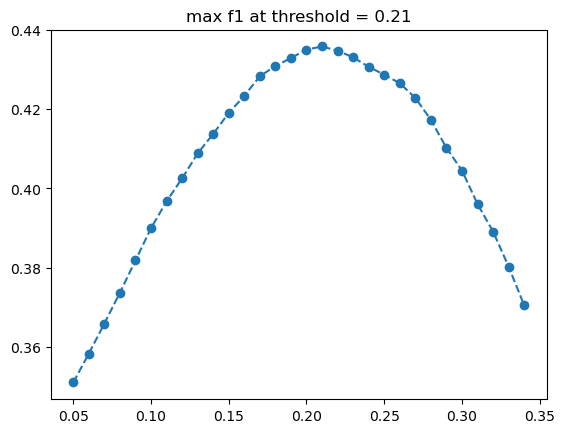

In [79]:
plt.plot(threshold, f1, '--o')
plt.title(f'max f1 at threshold = {best_threshold}')

In [80]:
y_prob = model.predict_proba(X_out)[:, 1]

In [81]:
best_pred = np.where(y_prob>best_threshold, 1, 0)

In [88]:
mat = pd.DataFrame(confusion_matrix(y_out, best_pred))

In [90]:
mat.columns = ['fully paid', 'charged off']
mat.index = ['fully paid', 'charged off']

Text(50.72222222222221, 0.5, 'true')

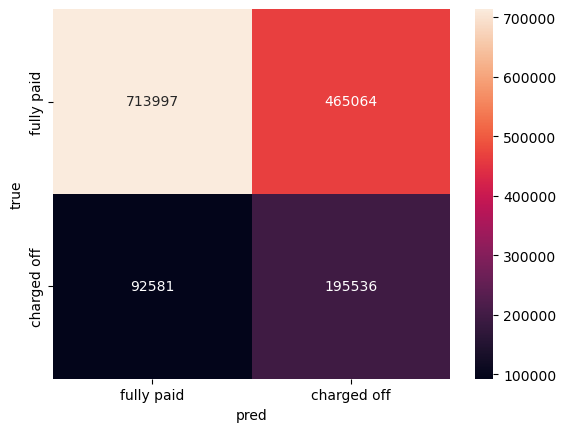

In [92]:
sns.heatmap(mat, annot=True, fmt='.0f')
plt.xlabel('pred')
plt.ylabel('true')

In [85]:
mat = confusion_matrix(y_out, best_pred)

In [86]:
mat[1]/mat.sum(axis=1)[1]

array([0.32133126, 0.67866874])

Evaluate the performance by comparing the ROI

In [2]:
with open('db_config.json', 'r') as json_file:
    db_config = json.load(json_file)

try:
    # Attempt to connect to the MySQL server
    connection = mysql.connector.connect(**db_config)

    # Check if the connection is successful
    if connection.is_connected():
        print("Connected to MySQL Server")
    
    eval_df_2 = pd.read_sql("SELECT ROI, IRR FROM matured_loan", connection)

    # Close the connection
    connection.close()

except mysql.connector.Error as err:
    print(f"Error: {err}")
    print("Failed to connect to MySQL Server")

Connected to MySQL Server


C:\Users\User\AppData\Local\Temp\ipykernel_18508\2324452014.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  eval_df_2 = pd.read_sql("SELECT ROI, IRR FROM matured_loan", connection)


In [116]:
eval_df = X_out.copy(deep=True)

In [117]:
eval_df['true'] = y_out
eval_df['pred'] = best_pred

In [124]:
eval_df = pd.concat([eval_df.iloc[:, -2:], eval_df_2.iloc[300000:]], axis=1)
del eval_df_2

In [128]:
(eval_df.loc[eval_df['pred']==0, 'ROI'].mean() - eval_df.loc[:, 'ROI'].mean())/eval_df.loc[:, 'ROI'].mean()

0.5846498746470772